In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
import scipy.spatial.distance as ssd


from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

In [16]:
# 1. Data loading
results_folder = 'results/GSE112026/'
df = pd.read_csv(results_folder+'stable_markers_with_friends_in_The_Run.csv', sep=';')

# 2. Prepare sets (Sets of friends)
# Group by marker and collect all friends into a set
marker_groups = df.groupby('marker')['friend'].apply(set)
markers = marker_groups.index.tolist()
n_markers = len(markers)

# 3. Compute Jaccard matrix (Standard Jaccard)
jaccard_matrix = pd.DataFrame(index=markers, columns=markers, dtype=float)

# For demonstration show calculation example for one pair
example_pair = None

for i in range(n_markers):
    for j in range(i, n_markers):
        marker_a = markers[i]
        marker_b = markers[j]
        
        set_a = marker_groups[marker_a]
        set_b = marker_groups[marker_b]
        
        intersection = len(set_a.intersection(set_b))
        union = len(set_a.union(set_b))
        
        if union > 0:
            score = intersection / union
        else:
            score = 0.0
            
        jaccard_matrix.iloc[i, j] = score
        jaccard_matrix.iloc[j, i] = score
        
        # Save an example non-trivial pair (score between 0 and 1)
        if example_pair is None and 0.2 < score < 0.8:
            example_pair = {
                'Marker A': marker_a,
                'Marker B': marker_b,
                'Intersection': set_a.intersection(set_b),
                'Union Size': union,
                'Score': score
            }

# 4. Save matrix
# jaccard_matrix.to_csv('simple_jaccard_matrix.csv')


<Figure size 1200x1200 with 0 Axes>

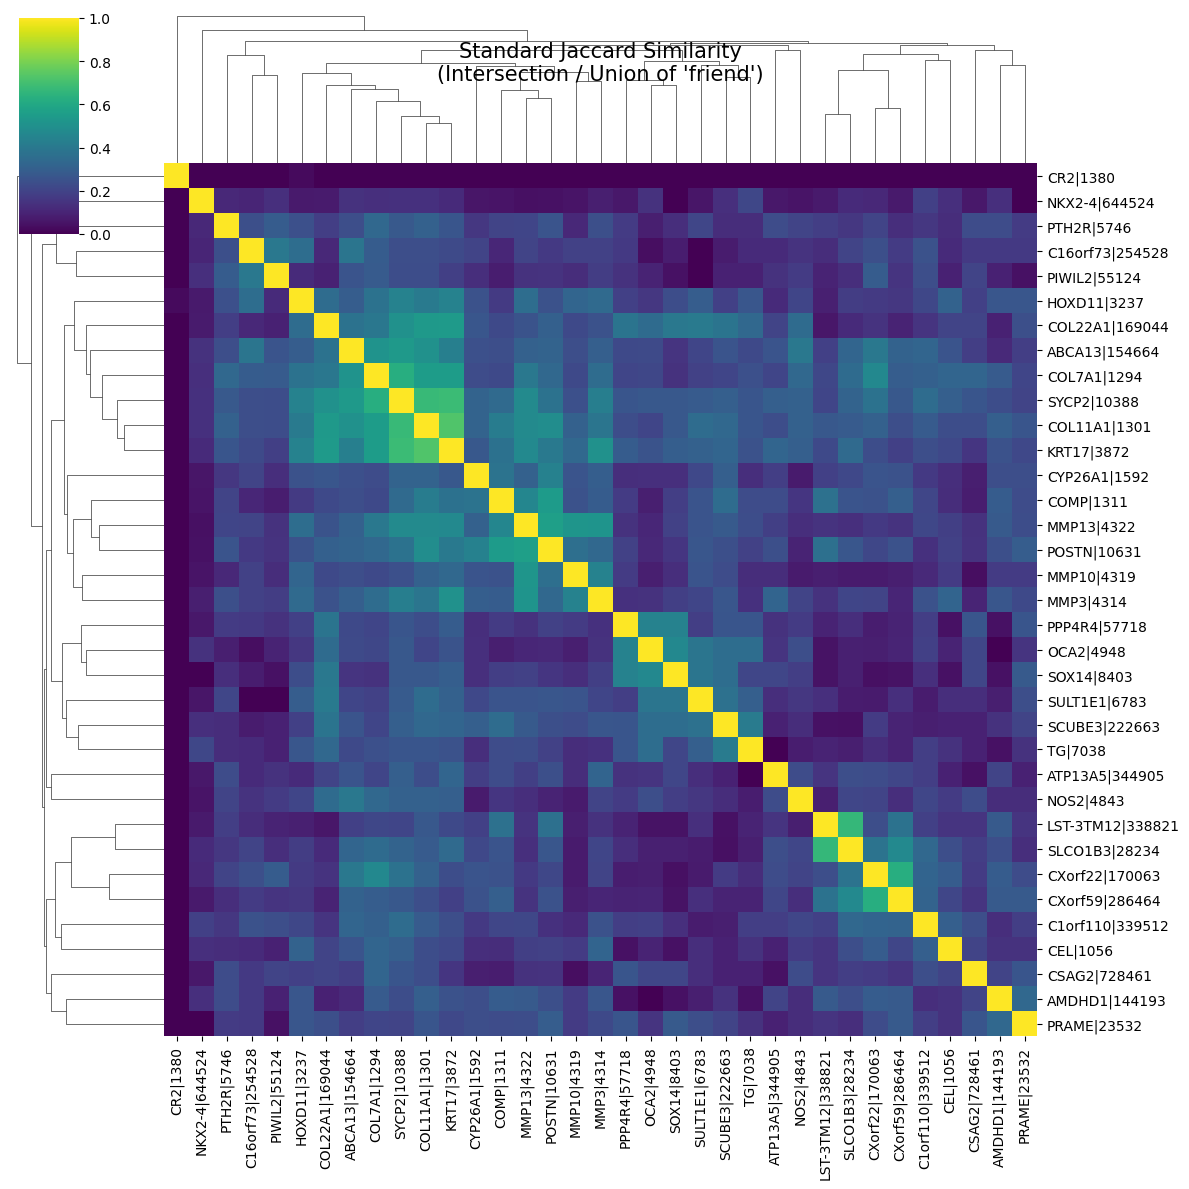

=== Example Jaccard calculation ===
Marker A: ABCA13|154664
Marker B: ATP13A5|344905
Intersection (8): ['HNSCC42', 'HNSCC24', 'HNSCC5', 'HNSCC23', 'HNSCC9']...
Union size: 31
Jaccard Index = 8 / 31 = 0.2581


In [17]:
# 5. Visualization (Clustermap)
dist_matrix = 1 - jaccard_matrix
condensed_dist = ssd.squareform(dist_matrix.values)
linkage_matrix = linkage(condensed_dist, method='average')

plt.figure(figsize=(12, 12))
g = sns.clustermap(jaccard_matrix, 
                   row_linkage=linkage_matrix, 
                   col_linkage=linkage_matrix,
                   cmap="viridis", 
                   figsize=(12, 12),
                   dendrogram_ratio=(0.15, 0.15))

g.ax_heatmap.set_title("Standard Jaccard Similarity\n(Intersection / Union of 'friend')", pad=60, fontsize=15)
plt.savefig(results_folder+'simple_jaccard_clustermap.png')
plt.show()

# 6. Example output and clusters
print("=== Example Jaccard calculation ===")
if example_pair:
    print(f"Marker A: {example_pair['Marker A']}")
    print(f"Marker B: {example_pair['Marker B']}")
    print(f"Intersection ({len(example_pair['Intersection'])}): {list(example_pair['Intersection'])[:5]}...")
    print(f"Union size: {example_pair['Union Size']}")
    print(f"Jaccard Index = {len(example_pair['Intersection'])} / {example_pair['Union Size']} = {example_pair['Score']:.4f}")


# k = 9
# clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
# results = pd.DataFrame({'Marker': markers, 'Cluster': clusters})
# results = results.sort_values(['Cluster', 'Marker'])

# print(f"\n=== Clusters (Standard Jaccard, k={k}) ===")
# for cid in sorted(results['Cluster'].unique()):
#     genes = results[results['Cluster'] == cid]['Marker'].tolist()
#     print(f"\nCluster {cid} ({len(genes)} genes):")
#     for g in genes:
#         print(f" - {g}")

In [18]:
def calculate_ruzicka_similarity(df, rank_col='friend.rank', normalization='sqrt'):
    """
    Compute weighted Jaccard (Ruzicka Similarity) based on ranks.
    """
    # 1. Build rank matrix (Rows=Markers, Columns=Friends)
    pivot_ranks = df.pivot(index='marker', columns='friend', values=rank_col)
    
    # 2. Convert ranks to weights
    if normalization == 'sqrt':
        # Gentle decay of importance (recommended)
        weights_matrix = 1.0 / np.sqrt(pivot_ranks)
    elif normalization == 'inverse':
        # Steeper decay (1/rank)
        weights_matrix = 1.0 / pivot_ranks
    else:
        # No normalization (presence only, all weights = 1)
        weights_matrix = pivot_ranks.notnull().astype(float)
        
    # Fill missing values with zeros (no relationship = weight 0)
    weights_matrix = weights_matrix.fillna(0.0)
    
    # 3. Ruzicka similarity calculation
    # J = Sum(Min(A, B)) / Sum(Max(A, B))
    
    markers = weights_matrix.index.tolist()
    n_markers = len(markers)
    W = weights_matrix.values
    
    sim_matrix = np.zeros((n_markers, n_markers))
    
    print("Starting similarity matrix computation...")
    
    for i in range(n_markers):
        for j in range(i, n_markers):
            vec_a = W[i]
            vec_b = W[j]
            
            numerator = np.sum(np.minimum(vec_a, vec_b))
            denominator = np.sum(np.maximum(vec_a, vec_b))
            
            if denominator != 0:
                score = numerator / denominator
            else:
                score = 0.0
            
            sim_matrix[i, j] = score
            sim_matrix[j, i] = score
            
    # Convert to DataFrame for convenience
    sim_df = pd.DataFrame(sim_matrix, index=markers, columns=markers)
    
    return sim_df, weights_matrix


Starting similarity matrix computation...
Matrix saved to 'weighted_jaccard_matrix.csv'
Figure saved to 'weighted_jaccard_clustermap.png'


<Figure size 1200x1200 with 0 Axes>

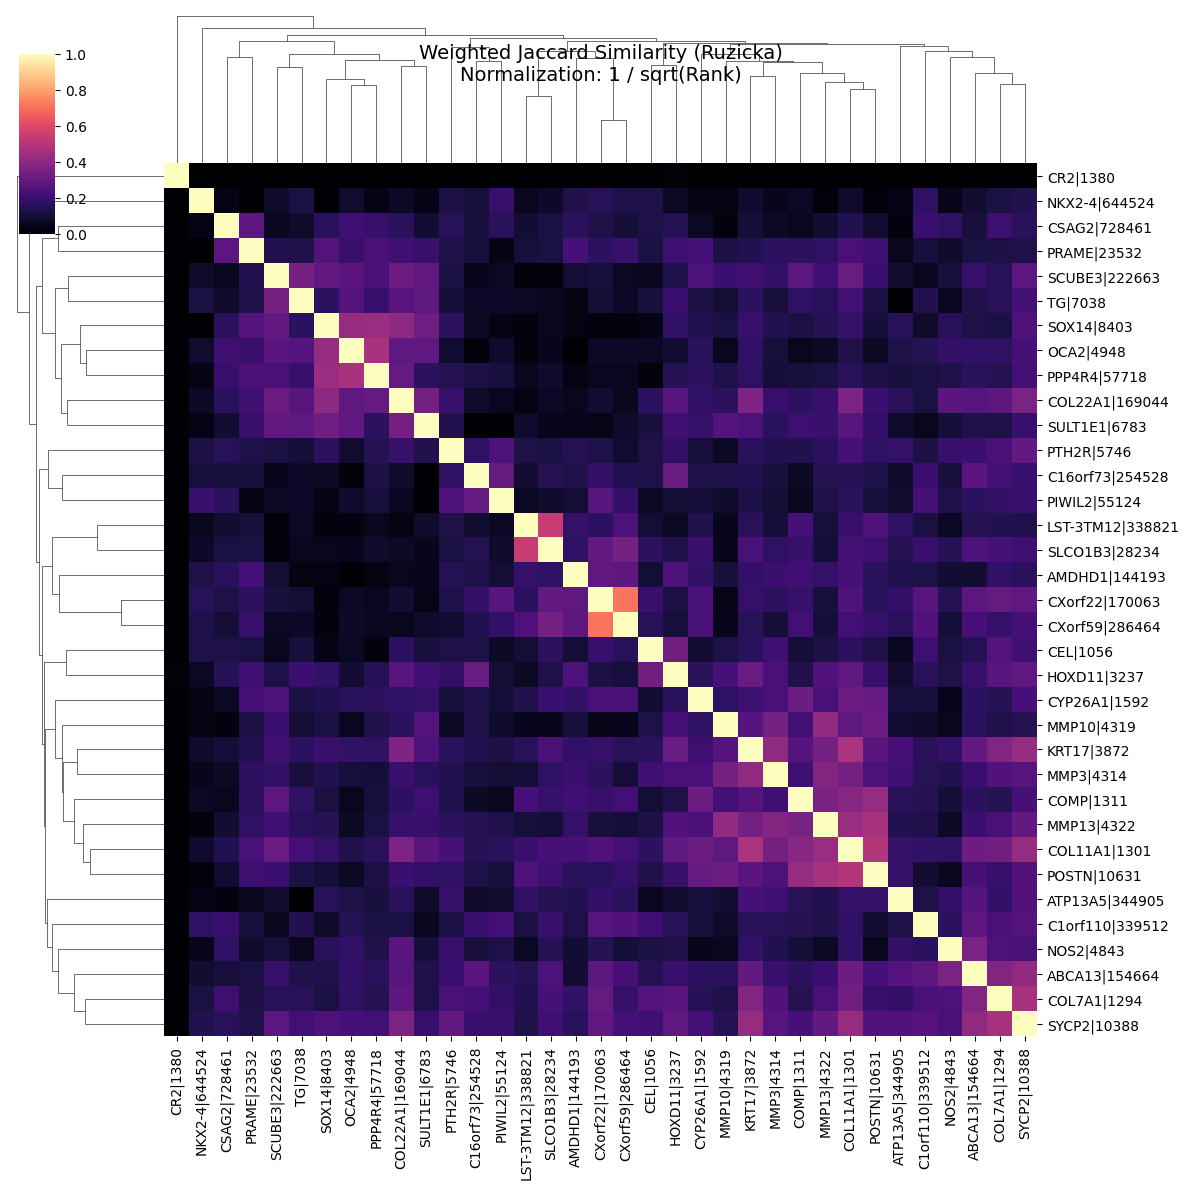

In [19]:
# --- RUN ---

# 1. Load file
#file_path = 'NEW_stable_markers_with_friends_in_The_Run.csv' # Specify your path
#df = pd.read_csv(file_path, sep=';')

# 2. Calculation
similarity_matrix, weights = calculate_ruzicka_similarity(df, normalization='sqrt')

# 3. Save matrix to file (to open in Excel)
similarity_matrix.to_csv(results_folder+'weighted_jaccard_matrix.csv', sep=';')
print("Matrix saved to 'weighted_jaccard_matrix.csv'")

# 4. Visualization and clustering
# Convert similarity to distance (1 - similarity) for clustering algorithm
dist_matrix = 1 - similarity_matrix
# Remove possible tiny negative values and diagonal
np.fill_diagonal(dist_matrix.values, 0)
dist_matrix = dist_matrix.clip(lower=0)

# Build hierarchy (Average Linkage)
condensed_dist = squareform(dist_matrix.values)
linkage_matrix = linkage(condensed_dist, method='average')

# Draw heatmap

plt.figure(figsize=(12, 12))
g = sns.clustermap(similarity_matrix, 
                   row_linkage=linkage_matrix, 
                   col_linkage=linkage_matrix,
                   cmap="magma", 
                   figsize=(12, 12),
                   dendrogram_ratio=(0.15, 0.15),
                   cbar_pos=(0.02, 0.8, 0.03, 0.15))

g.ax_heatmap.set_title("Weighted Jaccard Similarity (Ruzicka)\nNormalization: 1 / sqrt(Rank)", pad=60, fontsize=14)
plt.savefig(results_folder+'weighted_jaccard_clustermap.png', dpi=300)
print("Figure saved to 'weighted_jaccard_clustermap.png'")
plt.show()


Calculating Silhouette Scores...


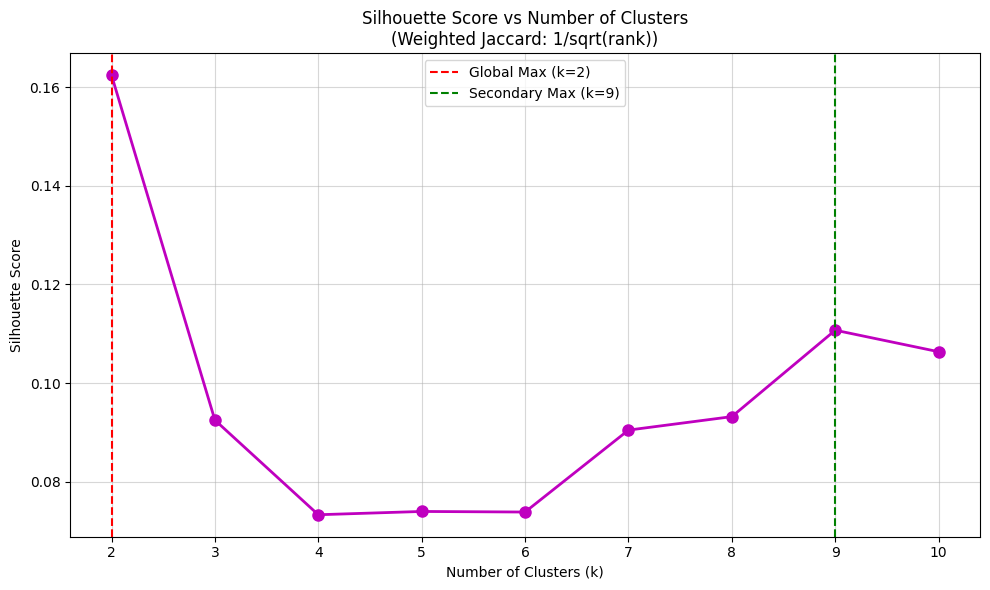

Global Optimum k: 2
Secondary (Functional) Optimum k: 9


In [20]:

scores = []
range_k = range(2, 11)
best_k = 2
best_score = -1

print("Calculating Silhouette Scores...")
for k in range_k:
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    if 1 < len(np.unique(labels)) < n_markers:
        score = silhouette_score(dist_matrix, labels, metric='precomputed')
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k

# Find secondary optimum (local max after k=2)
# Often k=2 just separates one outlier. We look for the first significant peak after that.
local_max_k = best_k
if best_k == 2 and len(scores) > 2:
    sub_scores = scores[1:] # indices 0 corresponds to k=2, so index 1 is k=3
    # Simple heuristic: find max in the remaining
    max_idx = np.argmax(sub_scores)
    if sub_scores[max_idx] > 0:
        local_max_k = range_k[1:][max_idx]

# 5. Plotting
plt.figure(figsize=(10, 6))
plt.plot(range_k, scores, 'mo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Global Max (k={best_k})')
if local_max_k != best_k:
    plt.axvline(x=local_max_k, color='g', linestyle='--', label=f'Secondary Max (k={local_max_k})')

plt.title('Silhouette Score vs Number of Clusters\n(Weighted Jaccard: 1/sqrt(rank))')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(results_folder+'silhouette_weighted_new.png')
plt.show()

print(f"Global Optimum k: {best_k}")
print(f"Secondary (Functional) Optimum k: {local_max_k}")

# # 6. List Genes for the Functional Optimum
# target_k = local_max_k 
# labels = fcluster(linkage_matrix, t=target_k, criterion='maxclust')
# results = pd.DataFrame({'Marker': markers, 'Cluster': labels})
# results = results.sort_values(['Cluster', 'Marker'])

# print(f"\n=== Cluster Composition (k={target_k}) ===")
# for cid in sorted(results['Cluster'].unique()):
#     genes = results[results['Cluster'] == cid]['Marker'].tolist()
#     print(f"\nCluster {cid} ({len(genes)} genes):")
#     for g in genes:
#         print(f" - {g}")

In [21]:
# 5. Get gene lists
# Cut dendrogram into k=7 clusters (defined earlier as optimum)
k = local_max_k
clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')

results = pd.DataFrame({'Marker': similarity_matrix.index, 'Cluster': clusters})
results = results.sort_values(['Cluster', 'Marker'])

print(f"\n=== Clustering results (k={k}) ===")
for cid in sorted(results['Cluster'].unique()):
    genes = results[results['Cluster'] == cid]['Marker'].tolist()
    print(f"\nCluster {cid} ({len(genes)} genes):")
    for g in genes:
        print(f" - {g}")


=== Clustering results (k=9) ===

Cluster 1 (2 genes):
 - CSAG2|728461
 - PRAME|23532

Cluster 2 (7 genes):
 - COL22A1|169044
 - OCA2|4948
 - PPP4R4|57718
 - SCUBE3|222663
 - SOX14|8403
 - SULT1E1|6783
 - TG|7038

Cluster 3 (3 genes):
 - C16orf73|254528
 - PIWIL2|55124
 - PTH2R|5746

Cluster 4 (5 genes):
 - AMDHD1|144193
 - CXorf22|170063
 - CXorf59|286464
 - LST-3TM12|338821
 - SLCO1B3|28234

Cluster 5 (2 genes):
 - CEL|1056
 - HOXD11|3237

Cluster 6 (8 genes):
 - COL11A1|1301
 - COMP|1311
 - CYP26A1|1592
 - KRT17|3872
 - MMP10|4319
 - MMP13|4322
 - MMP3|4314
 - POSTN|10631

Cluster 7 (6 genes):
 - ABCA13|154664
 - ATP13A5|344905
 - C1orf110|339512
 - COL7A1|1294
 - NOS2|4843
 - SYCP2|10388

Cluster 8 (1 genes):
 - NKX2-4|644524

Cluster 9 (1 genes):
 - CR2|1380
